# Setting up Spark

Start a pySpark session including Diana-Hep spark-root and histogrammar APIs

In [1]:
import pyspark.sql

#### CLUSTER CONFIG ####
# 5 Nodes
# 2 cores per Node
# 2.9 GB RAM per Node
#######################

num_cores = 2 # core per executer
num_executors = 4

session = pyspark.sql.SparkSession.builder \
    .master('spark://10.64.22.198:7077') \
    .appName('DemoWithML') \
    .config('spark.jars.packages','org.diana-hep:spark-root_2.11:0.1.16,org.diana-hep:histogrammar-sparksql_2.11:1.0.4') \
    .config('spark.driver.extraClassPath','/opt/hadoop/share/hadoop/common/lib/EOSfs.jar') \
    .config('spark.executor.extraClassPath','/opt/hadoop/share/hadoop/common/lib/EOSfs.jar') \
    .config("spark.serializer","org.apache.spark.serializer.KryoSerializer") \
    .config('spark.executor.memory','2g') \
    .config('spark.executor.cores',`num_cores`) \
    .config('spark.executor.instances', `num_executors`) \
    .config('spark.cores.max','9') \
    .getOrCreate()
    
sqlContext = session

print 'SparkSQL sesssion created'

SparkSQL sesssion created


# Loading root files stored remotely on EOS via xrootd

Loading root files (NanoAOD CMS format) from CERN public EOS area via xrootd.
Trees are read using the spark-root

In [2]:
from pyspark.sql.functions import lit
from samples import *

DFList = [] 

for s in samples:
    print 'Loading {0} sample from EOS file'.format(s) 
    dsPath = "root://eospublic.cern.ch//eos/opstest/cmspd-bigdata/"+samples[s]['filename']    
    tempDF = sqlContext.read \
                .format("org.dianahep.sparkroot") \
                .option("tree", "Events") \
                .load(dsPath)\
                .withColumn("sample", lit(s))                
    DFList.append(tempDF)

Loading ZH sample from EOS file
Loading TT sample from EOS file
Loading WW sample from EOS file
Loading SingleMuon sample from EOS file
Loading ZZ sample from EOS file
Loading DYJetsToLL sample from EOS file
Loading WZ sample from EOS file


# Access DataFrame content

Get list of columns in the DataFrame ("branches" of the equivalent ROOT TTree).

In [3]:
DFList[0].printSchema()

root
 |-- run: integer (nullable = true)
 |-- luminosityBlock: integer (nullable = true)
 |-- event: long (nullable = true)
 |-- CaloMET_phi: float (nullable = true)
 |-- CaloMET_pt: float (nullable = true)
 |-- CaloMET_sumEt: float (nullable = true)
 |-- nElectron: integer (nullable = true)
 |-- Electron_deltaEtaSC: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Electron_dr03EcalRecHitSumEt: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Electron_dr03HcalDepth1TowerSumEt: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Electron_dr03TkSumPt: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Electron_dxy: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Electron_dxyErr: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Electron_dxyErr_ugo: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Electron_d

# Data reduction

Subsets of interesting attributes can be selected via 'select' operations on the DataFrames (equivalent to "pruning" steps in ROOT-based frameworks).

All datasets can be joint into a single DataFrame (e.g. collecting data from various samples).

In [4]:
columns = [
    ### MUON
    'Muon_pt',
    'Muon_eta',
    'Muon_phi',
    'Muon_mass',
    'Muon_charge',
    'Muon_mediumId',
    'Muon_softId',
    'Muon_tightId',
    'nMuon',
    ### SAMPLE
    'sample',
    ### Jet
    'Jet_pt',
]

# Select columns from dataframe
DF = DFList[0].select(columns)
DF.printSchema()

# Merge all dataset into a single dataframe
for df_ in DFList[1:]:
    DF = DF.union(df_.select(columns))

print 'Partitions: {}'.format(DF.rdd.getNumPartitions())

root
 |-- Muon_pt: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_eta: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_phi: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_mass: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_charge: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- Muon_mediumId: array (nullable = true)
 |    |-- element: boolean (containsNull = true)
 |-- Muon_softId: array (nullable = true)
 |    |-- element: boolean (containsNull = true)
 |-- Muon_tightId: array (nullable = true)
 |    |-- element: boolean (containsNull = true)
 |-- nMuon: integer (nullable = true)
 |-- sample: string (nullable = false)
 |-- Jet_pt: array (nullable = true)
 |    |-- element: float (containsNull = true)

Partitions: 7


# Data selection

Selection of events based on features is obtained via a 'filter' operation.

Number of entries is obtained by 'count'.

In [5]:
print 'total number of events in the DataFrame  = ', DF.count()
print 'events in the DataFrame with \"nMuon > 0\" = ', DF.filter('nMuon > 0').count()

total number of events in the DataFrame  =  3701741
events in the DataFrame with "nMuon > 0" =  1718768


# Caching - 1

Dataframes can be cached into memory, shared across the Spark cluster nodes, for a faster access.

Caching takes some time...

In [6]:
DF = DF.cache()

# Caching - 2

... but ensures fast data-handling operations afterwards.

In [7]:
print 'total number of events in the DataFrame  = ', DF.count()
print 'events in the DataFrame with \"nMuon > 0\" = ', DF.filter('nMuon > 0').count()

total number of events in the DataFrame  =  3701741
events in the DataFrame with "nMuon > 0" =  1718768


# Data inspection


Events can be inspected with 'show' (as in TTree.Show() ), also concatenating 'select' and 'filter'.

In [8]:
DF.filter(DF['sample'] == 'DYJetsToLL')\
  .select('sample','nMuon','Muon_pt','Muon_eta','Muon_phi','Muon_charge')\
  .show(5)

+----------+-----+-----------+------------+------------+-----------+
|    sample|nMuon|    Muon_pt|    Muon_eta|    Muon_phi|Muon_charge|
+----------+-----+-----------+------------+------------+-----------+
|DYJetsToLL|    1| [34.75507]|[-1.3212891]|[-1.0375977]|        [1]|
|DYJetsToLL|    0|         []|          []|          []|         []|
|DYJetsToLL|    1|[3.3921983]|[-1.5285645]|[-0.2514038]|       [-1]|
|DYJetsToLL|    0|         []|          []|          []|         []|
|DYJetsToLL|    0|         []|          []|          []|         []|
+----------+-----+-----------+------------+------------+-----------+
only showing top 5 rows



# Create derivate quantities and structures - 1

User defined functions can be used for transformations evalueted row by row to compute derived quantity, such as invaraint mass of two physics objects involving multiple column.
The return value is added as a new column in the output DataFrame.

Dimuon candidate structure is created as an example.

In [9]:
from math import *
from pyspark.sql.types import *

dimuonSchema = StructType([
    StructField("pass", BooleanType(), False),   # True if filled / False if default(empty) 
    #
    StructField("mass", FloatType(), False),     # Dimuon mass
    StructField("pt", FloatType(), False),       # Dimuon pt
    StructField("eta", FloatType(), False),      # Dimuon eta
    StructField("phi", FloatType(), False),      # Dimuon phi
    StructField("dPhi", FloatType(), False),     # DeltaPhi(mu1,mu2)
    StructField("dR", FloatType(), False),       # DeltaR(mu1,mu2)
    StructField("dEta", FloatType(), False),     # DeltaEta(mu1,mu2)
    #
    StructField("mu1_pt", FloatType(), False),   # leading mu pT 
    StructField("mu2_pt", FloatType(), False),   # sub-leading mu pT 
    StructField("mu1_eta", FloatType(), False),  # leading mu eta
    StructField("mu2_eta", FloatType(), False),  # sub-leading mu eta
    StructField("mu1_phi", FloatType(), False),  # leading mu phi
    StructField("mu2_phi", FloatType(), False),  # sub-leading mu phi
])

def binaryWeight(pt):
    for idx in range(len(pt)):
        if pt[idx]>50:
            return 0.
        else:
            return 1.

def deltaPhi(phi1,phi2):
    ## Catch if being called with two objects
    if type(phi1) != float and type(phi1) != int:
        phi1 = phi1.phi
    if type(phi2) != float and type(phi2) != int:
        phi2 = phi2.phi
    ## Otherwise
    dphi = (phi1-phi2)
    while dphi >  pi: dphi -= 2*pi
    while dphi < -pi: dphi += 2*pi
    return dphi

def deltaR(eta1,phi1,eta2=None,phi2=None):
    ## catch if called with objects
    if eta2 == None:
        return deltaR(eta1.eta,eta1.phi,phi1.eta,phi1.phi)
    ## otherwise
    return hypot(eta1-eta2, deltaPhi(phi1,phi2))

def invMass(pt1, pt2, eta1, eta2, phi1, phi2, mass1, mass2):
    #
    theta1 = 2.0*atan(exp(-eta1))
    px1    = pt1 * cos(phi1)
    py1    = pt1 * sin(phi1)
    pz1    = pt1 / tan(theta1)
    E1     = sqrt(px1**2 + py1**2 + pz1**2 + mass1**2)

    theta2 = 2.0*atan(exp(-eta2))
    px2    = pt2 * cos(phi2)
    py2    = pt2 * sin(phi2)
    pz2    = pt2 / tan(theta2)
    E2     = sqrt(px2**2 + py2**2 + pz2**2 + mass2**2)

    themass  = sqrt((E1 + E2)**2 - (px1 + px2)**2 - (py1 + py2)**2 - (pz1 + pz2)**2)
    thept    = sqrt((px1 + px2)**2 + (py1 + py2)**2)
    thetheta = atan( thept / (pz1 + pz2) )        
    theeta   = 0.5*log( (sqrt((px1 + px2)**2 + (py1 + py2)**2 + (pz1 + pz2)**2)+(pz1 + pz2))/(sqrt((px1 + px2)**2 + (py1 + py2)**2 + (pz1 + pz2)**2)-(pz1 + pz2)) )
    thephi   = asin((py1 + py2)/thept)

    delPhi = deltaPhi(phi1,phi2)
    delR   = deltaR(eta1,phi1,eta2,phi2)
    delEta = eta1-eta2

    return (themass, thept, theeta, thephi, delPhi, delR, delEta)

def dimuonCandidate(pt, eta, phi, mass, charge, mediumid):
    # default class implementation   
    default_ = (False, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
    
    """
    Z->mm candidate from arbitrary muon selection:
      N(mu) >= 2
      pT > 30, 10
      abs(eta) < 2.4, 2.4
      mediumId muon
      opposite charge
    """
    
    if len(pt) < 2:
        return default_
    
    #Identify muon candidate
    leadingIdx = None
    trailingIdx = None
 
    for idx in range(len(pt)):
        if leadingIdx == None:
            if pt[idx] > 30 and abs(eta[idx]) < 2.4 and mediumid[idx]:
                leadingIdx = idx
        elif trailingIdx == None:
            if pt[idx] > 10 and abs(eta[idx]) < 2.4 and mediumid[idx]:
                trailingIdx = idx
        else:
            if pt[idx] > 10 and abs(eta[idx]) < 2.4 and mediumid[idx]:
                return default_

    if leadingIdx != None and trailingIdx != None and charge[leadingIdx] != charge[trailingIdx]:            
        # Candidate found
        dimuon_   = (True,) + \
                    invMass(pt[leadingIdx], pt[trailingIdx],
                            eta[leadingIdx], eta[trailingIdx],
                            phi[leadingIdx], phi[trailingIdx],
                            mass[leadingIdx], mass[trailingIdx]) + \
                    (pt[leadingIdx], pt[trailingIdx],
                     eta[leadingIdx], eta[trailingIdx],
                     phi[leadingIdx], phi[trailingIdx])
                
        return dimuon_
    else:
        return default_    

# Create derivate quantities and structures - 2

And a generic function filling the candidate structure can be defined.

# Create derivate quantities and structures - 3

Finally, a dimuon candidate structure can be appended to the DataFrame as an additional column

In [10]:
from pyspark.sql.functions import udf
dimuonUDF = udf(dimuonCandidate, dimuonSchema)
biweightUDF = udf(binaryWeight, FloatType())

DF = DF.withColumn('Dimuon', dimuonUDF ("Muon_pt",
                                        "Muon_eta",
                                        "Muon_phi",
                                        "Muon_mass",
                                        "Muon_charge",
                                        "Muon_mediumId")
                  )

DF = DF.withColumn('pseudoweight', biweightUDF("Muon_pt"))

DF.where('Dimuon.pass == True').select('Dimuon').show(3)
DF.where('Dimuon.pass == True').select('pseudoweight').show(3)


+--------------------+
|              Dimuon|
+--------------------+
|[true,102.49685,5...|
|[true,84.92543,5....|
|[true,92.46844,15...|
+--------------------+
only showing top 3 rows

+------------+
|pseudoweight|
+------------+
|         0.0|
|         1.0|
|         0.0|
+------------+
only showing top 3 rows



In [11]:
DF.where('Dimuon.pass == True').where('Muon_pt[0] > 40').select('pseudoweight','Muon_pt').show(20)

+------------+--------------------+
|pseudoweight|             Muon_pt|
+------------+--------------------+
|         0.0|[80.39047, 33.70294]|
|         1.0|[40.015675, 37.21...|
|         0.0|[120.16272, 55.47...|
|         0.0|[51.66909, 34.39384]|
|         0.0|[60.870556, 32.68...|
|         0.0|[99.84009, 31.262...|
|         1.0|[45.05578, 20.652...|
|         0.0|[100.25968, 55.49...|
|         0.0|[65.764824, 27.91...|
|         0.0|[87.095276, 78.07...|
|         0.0|[277.19217, 67.34...|
|         0.0|[149.8475, 114.19...|
|         0.0|[58.78283, 34.128...|
|         0.0|[55.77872, 27.862...|
|         0.0|[53.38735, 22.32227]|
|         0.0|[117.69218, 84.67...|
|         0.0|[98.027534, 93.73...|
|         0.0|[94.99625, 65.04307]|
|         0.0|[225.47717, 83.42...|
|         0.0|[69.49928, 34.36113]|
+------------+--------------------+
only showing top 20 rows



# Get statistics info about the data

Exploit pySparkSql functions to get statistical insights on the DataFrame

In [12]:
from pyspark.sql.functions import *

print 'Number of events, pre-selection level'

DF.groupBy("sample").count().show()

print 'Number of events, Dimuon invariant mass in [70-110] GeV'

DF.where( (col("Dimuon.mass") > 70) & (col("Dimuon.mass") < 110) ).groupBy("sample").count().show()

print 'Mean of Dimuon mass, evaluated in [70-110] GeV range'

DF.where( (col("Dimuon.mass") > 70) & (col("Dimuon.mass") < 110) ).groupBy('sample').mean('Dimuon.mass').show()

print 'Description of Dimuon mass features for SingleMuon dataset only, evaluated in [70-110] GeV range'

DF.where( (col("Dimuon.mass") > 70) & (col("Dimuon.mass") < 110) & (DF["sample"] == "SingleMuon") ).describe('Dimuon.mass').show()


Number of events, pre-selection level
+----------+-------+
|    sample|  count|
+----------+-------+
|        ZZ| 480144|
|        WW| 348954|
|        ZH|1039542|
|DYJetsToLL| 549790|
|SingleMuon| 477186|
|        WZ| 424048|
|        TT| 382077|
+----------+-------+

Number of events, Dimuon invariant mass in [70-110] GeV
+----------+------+
|    sample| count|
+----------+------+
|        ZZ| 16201|
|        WW|   710|
|        ZH|188830|
|DYJetsToLL| 67831|
|SingleMuon| 13934|
|        WZ|  7209|
|        TT|  1760|
+----------+------+

Mean of Dimuon mass, evaluated in [70-110] GeV range
+----------+--------------------------+
|    sample|avg(Dimuon.mass AS `mass`)|
+----------+--------------------------+
|        ZZ|         90.39599790585481|
|        WW|         88.08453911794743|
|        ZH|         90.33277579983658|
|DYJetsToLL|         90.19341036229169|
|SingleMuon|         89.91447557800039|
|        WZ|         90.19251177561962|
|        TT|         86.54928711977873|


# Plotting the Zpeak mass

In [13]:
# Load libraries, and append histogrammar functionalities to dataframe
import matplotlib.pyplot as plt
%matplotlib inline
import histogrammar as hg
import histogrammar.sparksql
import numpy as np

DF = DF.where( (col("Dimuon.mass") > 70) & (col("Dimuon.mass") < 110) )

hg.sparksql.addMethods(DF)

plots = hg.UntypedLabel(
    # 1d histograms
    LeadPtW      = hg.Bin(50, 30, 180,   DF['Dimuon.mu1_pt'], hg.Sum(DF['pseudoweight'])),
    LeadPt       = hg.Bin(50, 30, 180,   DF['Dimuon.mu1_pt']),
    LeadPtEta    = hg.Bin(48, -2.4, 2.4, DF['Dimuon.mu1_eta']),
    SubLeadPt    = hg.Bin(100, 0, 200,   DF['Dimuon.mu2_pt']),
    SubLeadPtEta = hg.Bin(48, -2.4, 2.4, DF['Dimuon.mu2_eta']),
    InvMass      = hg.Bin(80, 70, 110,   DF['Dimuon.mass']),
    DeltaR       = hg.Bin(50, 0, 5,      DF['Dimuon.dPhi']),
    DeltaPhi     = hg.Bin(64, -3.2, 3.2, DF['Dimuon.dR']),
)

# Make a set of histograms, categorized per-sample
bulkHisto = hg.Categorize(quantity = DF['sample'], value = plots)

# Fill from spark
bulkHisto.fillsparksql(df=DF)


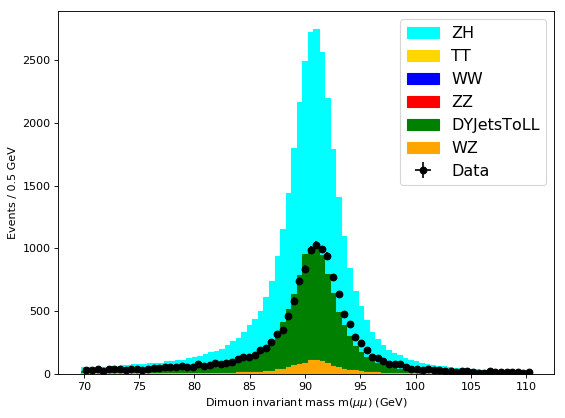

In [14]:
VARIABLE = 'InvMass'

fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

aHisto   = bulkHisto("SingleMuon")(VARIABLE)
nBins    = len(aHisto.values)
edges    = np.linspace(aHisto.low, aHisto.high, nBins + 1)
width    = (aHisto.high - aHisto.low) / nBins

plotVals = {}
for k in bulkHisto.bins:
    if k == 'SingleMuon':
        continue
    plotVals[k] = [x.toJson()['data']*0.19 for x in bulkHisto(k)(VARIABLE).values]
    plt.bar(edges[:-1], plotVals[k], width=width, label=k, color=samples[k]['color'], edgecolor=samples[k]['color'], fill=True)
    
xdata   = np.linspace(aHisto.low+0.5*width, aHisto.high+0.5*width, nBins)    
ydata   = [x.toJson()['data'] for x in bulkHisto('SingleMuon')(VARIABLE).values]
yerror  = [x**0.5 for x in ydata]

plt.errorbar(xdata, ydata, fmt='ko', label="Data", xerr=width/2, yerr=yerror, ecolor='black')

plt.xlabel('Dimuon invariant mass m($\mu\mu$) (GeV)')
plt.ylabel('Events / 0.5 GeV')
plt.legend(loc='upper right', fontsize='x-large', )


# Plotting with pseudoweight

THe leading Pt of muon

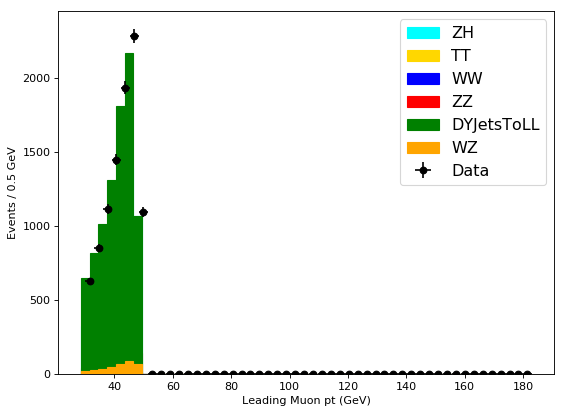

In [15]:
VARIABLE = 'LeadPtW'

fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

aHisto   = bulkHisto("SingleMuon")(VARIABLE)
nBins    = len(aHisto.values)
edges    = np.linspace(aHisto.low, aHisto.high, nBins + 1)
width    = (aHisto.high - aHisto.low) / nBins

plotVals = {}
for k in bulkHisto.bins:
    if k == 'SingleMuon':
        continue
    plotVals[k] = [x.sum*0.19 for x in bulkHisto(k)(VARIABLE).values]
    plt.bar(edges[:-1], plotVals[k], width=width, label=k, color=samples[k]['color'], edgecolor=samples[k]['color'], fill=True)
    
xdata   = np.linspace(aHisto.low+0.5*width, aHisto.high+0.5*width, nBins)    
ydata   = [x.sum for x in bulkHisto('SingleMuon')(VARIABLE).values]
yerror  = [x**0.5 for x in ydata]

plt.errorbar(xdata, ydata, fmt='ko', label="Data", xerr=width/2, yerr=yerror, ecolor='black')

plt.xlabel('Leading Muon pt (GeV)')
plt.ylabel('Events / 0.5 GeV')
plt.legend(loc='upper right', fontsize='x-large', )


The leading Pt without pseudoWeight

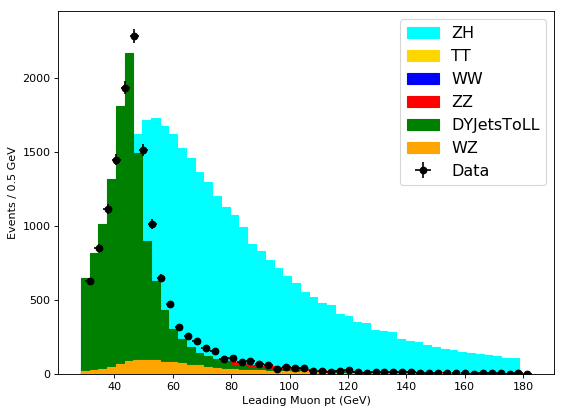

In [16]:
VARIABLE = 'LeadPt'

fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

aHisto   = bulkHisto("SingleMuon")(VARIABLE)
nBins    = len(aHisto.values)
edges    = np.linspace(aHisto.low, aHisto.high, nBins + 1)
width    = (aHisto.high - aHisto.low) / nBins

plotVals = {}
for k in bulkHisto.bins:
    if k == 'SingleMuon':
        continue
    plotVals[k] = [x.toJson()['data']*0.19 for x in bulkHisto(k)(VARIABLE).values]
    plt.bar(edges[:-1], plotVals[k], width=width, label=k, color=samples[k]['color'], edgecolor=samples[k]['color'], fill=True)
    
xdata   = np.linspace(aHisto.low+0.5*width, aHisto.high+0.5*width, nBins)    
ydata   = [x.toJson()['data'] for x in bulkHisto('SingleMuon')(VARIABLE).values]
yerror  = [x**0.5 for x in ydata]

plt.errorbar(xdata, ydata, fmt='ko', label="Data", xerr=width/2, yerr=yerror, ecolor='black')

plt.xlabel('Leading Muon pt (GeV)')
plt.ylabel('Events / 0.5 GeV')
plt.legend(loc='upper right', fontsize='x-large', )


# ML Learning Extension

Preparing dataframe for machin learning. Here we define the set of features distinguishing the signal VH and backgrounds.

In [19]:
from pyspark.sql.functions import udf
from pyspark.sql.functions import rand
from pyspark.ml.linalg import Vectors, VectorUDT
#from pyspark.mllib.linalg import Vectors, VectorUDT
vectorizer = udf(lambda x: Vectors.dense(x), VectorUDT())

##Construct Desire Features:
nFeatures = vectorizer(
    array(
        DF['nMuon'],
        DF['Muon_Pt'][0],
        DF['Muon_Eta'][0], 
        DF['Jet_Pt'][0], 
        DF['Muon_Eta'][0]
    )
) # 4 variables

pseudodata = DF.withColumn( "features" , nFeatures ).select("features","sample")

#Split 
pseudodata = pseudodata.where( (col('sample') == "DYJetsToLL") | (col('sample') == "ZH") )
#Rename sample to Label
dataset = pseudodata.selectExpr("features as features", "sample as label").orderBy(rand())

In [20]:
dataset.show(30)

+--------------------+----------+
|            features|     label|
+--------------------+----------+
|[2.0,139.26023864...|        ZH|
|[2.0,36.984821319...|DYJetsToLL|
|[2.0,284.72332763...|        ZH|
|[2.0,71.992889404...|        ZH|
|[2.0,155.34909057...|        ZH|
|[3.0,60.216964721...|        ZH|
|[3.0,99.590644836...|        ZH|
|[2.0,54.080379486...|        ZH|
|[2.0,45.742794036...|DYJetsToLL|
|[2.0,59.311889648...|DYJetsToLL|
|[2.0,45.777149200...|DYJetsToLL|
|[2.0,34.128368377...|        ZH|
|[2.0,205.33457946...|        ZH|
|[2.0,48.254188537...|        ZH|
|[2.0,71.951789855...|        ZH|
|[2.0,50.628849029...|        ZH|
|[4.0,56.703536987...|        ZH|
|[2.0,51.405845642...|        ZH|
|[2.0,30.347896575...|DYJetsToLL|
|[2.0,65.057128906...|        ZH|
|[2.0,82.043418884...|        ZH|
|[2.0,66.877273559...|        ZH|
|[2.0,118.97646331...|        ZH|
|[2.0,63.297161102...|        ZH|
|[2.0,60.689334869...|        ZH|
|[2.0,98.639686584...|        ZH|
|[2.0,37.27952

## A quick run through on our cluster landscape

In [21]:
#This variable is derived from the number of cores and executors, 
#and will be used to assign the number of model trainers.

num_workers = num_executors * num_cores

print("Number of desired executors: " + `num_executors`)
print("Number of desired cores / executor: " + `num_cores`)
print("Total number of workers: " + `num_workers`)

Number of desired executors: 4
Number of desired cores / executor: 2
Total number of workers: 8


## Preprocessing dataframe

In [22]:
from pyspark.ml.feature import StringIndexer

string_indexer = StringIndexer(inputCol="label", outputCol="index_label")
fitted_indexer = string_indexer.fit(dataset)
indexed_df = fitted_indexer.transform(dataset)

from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
fitted_scaler = scaler.fit(indexed_df)
scaled_df = fitted_scaler.transform(indexed_df)
print("The result of indexing and scaling. Each transformation adds new columns to the data frame:")
scaled_df.show(10)

The result of indexing and scaling. Each transformation adds new columns to the data frame:
+--------------------+----------+-----------+--------------------+
|            features|     label|index_label|     scaled_features|
+--------------------+----------+-----------+--------------------+
|[2.0,139.26023864...|        ZH|        0.0|[-0.4178635177813...|
|[2.0,36.984821319...|DYJetsToLL|        1.0|[-0.4178635177813...|
|[2.0,284.72332763...|        ZH|        0.0|[-0.4178635177813...|
|[2.0,71.992889404...|        ZH|        0.0|[-0.4178635177813...|
|[2.0,155.34909057...|        ZH|        0.0|[-0.4178635177813...|
|[3.0,60.216964721...|        ZH|        0.0|[1.86064228925686...|
|[3.0,99.590644836...|        ZH|        0.0|[1.86064228925686...|
|[2.0,54.080379486...|        ZH|        0.0|[-0.4178635177813...|
|[2.0,45.742794036...|DYJetsToLL|        1.0|[-0.4178635177813...|
|[2.0,59.311889648...|DYJetsToLL|        1.0|[-0.4178635177813...|
+--------------------+----------+----

After reading the dataset from storage, we will extract several metrics such as nb_features, which basically is the number of input neurons, and nb_classes, which is the number of classes (signal and background).

In [24]:
nb_features = len(scaled_df.select("features").take(1)[0]["features"])
#nb_classes = len(scaled_df.select("label").take(1)[0]["label"])
nb_classes = 1

print("Number of features: " + str(nb_features))
print("Number of classes: " + str(nb_classes))

Number of features: 5
Number of classes: 1


## Caching training set and test set in memory (WARNING)

plit up the dataset for training and testing purposes, and fetch some additional statistics on the number of training and testing instances.

In [25]:
# Finally, we create a trainingset and a testset.
(training_set, test_set) = scaled_df.randomSplit([0.7, 0.3])
training_set.cache()
test_set.cache()

DataFrame[features: vector, label: string, index_label: double, scaled_features: vector]

## Distributing the training and test set to the workers

In [26]:
test_set = test_set.repartition(num_workers)
training_set = training_set.repartition(num_workers)

num_test_set = test_set.count()
num_training_set = training_set.count()

print("Number of testset instances: " + str(num_test_set))
print("Number of trainingset instances: " + str(num_training_set))
print("Total number of instances: " + str(num_test_set + num_training_set))

Number of testset instances: 76812
Number of trainingset instances: 179871
Total number of instances: 256683


## Keras Model Construction

In [27]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
model = Sequential()
model.add(Dense(500, input_shape=(nb_features,)))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dropout(0.6))
model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
model.summary()

/usr/lib64/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               3000      
_________________________________________________________________
activation_1 (Activation)    (None, 500)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
activation_2 (Activation)    (None, 500)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)               250500    
__________

In [28]:
optimizer = 'adagrad'
loss = 'categorical_crossentropy'

## Model Evaluation

In [29]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from distkeras.transformers import LabelIndexTransformer
from distkeras.predictors import ModelPredictor

from distkeras.trainers import SingleTrainer
#from distkeras.trainers import AEASGD
#from distkeras.trainers import DOWNPOUR

def evaluate(model):
    global test_set

    metric_name = "f1"
    evaluator = MulticlassClassificationEvaluator(metricName=metric_name, predictionCol="prediction_index", labelCol="index_label")
    # Clear the prediction column from the testset.
    test_set = test_set.select("scaled_features", "label", "index_label")
    # Apply a prediction from a trained model.
    predictor = ModelPredictor(keras_model=trained_model, features_col="scaled_features")
    test_set = predictor.predict(test_set)
    # Transform the prediction vector to an indexed label.
    index_transformer = LabelIndexTransformer(output_dim=nb_classes)
    test_set = index_transformer.transform(test_set)
    # Store the F1 score of the SingleTrainer.
    score = evaluator.evaluate(test_set)
    
    return score

In [30]:
results = {}
time_spent = {}

## Model Training and evaluation: SingleTrainer

In [31]:
trainer = SingleTrainer(keras_model=model, loss=loss, worker_optimizer=optimizer, 
                        features_col="scaled_features", num_epoch=1, batch_size=64)
trained_model = trainer.train(training_set)

In [32]:
# Fetch the training time.
dt = trainer.get_training_time()
print("Time spent (SingleTrainer): " + `dt` + " seconds.")

# Evaluate the model.
score = evaluate(trained_model)
print("F1 (SingleTrainer): " + `score`)

# Store the training metrics.
results['single'] = score
time_spent['single'] = dt

Time spent (SingleTrainer): 6.00390887260437 seconds.
F1 (SingleTrainer): 0.6207073865418694


In [33]:
test_set.show()

+--------------------+----------+-----------+----------+----------------+
|     scaled_features|     label|index_label|prediction|prediction_index|
+--------------------+----------+-----------+----------+----------------+
|[-0.4178635177813...|DYJetsToLL|        1.0|     [1.0]|             0.0|
|[-0.4178635177813...|        ZH|        0.0|     [1.0]|             0.0|
|[-0.4178635177813...|DYJetsToLL|        1.0|     [1.0]|             0.0|
|[-0.4178635177813...|DYJetsToLL|        1.0|     [1.0]|             0.0|
|[-0.4178635177813...|DYJetsToLL|        1.0|     [1.0]|             0.0|
|[-0.4178635177813...|DYJetsToLL|        1.0|     [1.0]|             0.0|
|[-0.4178635177813...|DYJetsToLL|        1.0|     [1.0]|             0.0|
|[-0.4178635177813...|        ZH|        0.0|     [1.0]|             0.0|
|[-0.4178635177813...|DYJetsToLL|        1.0|     [1.0]|             0.0|
|[-0.4178635177813...|DYJetsToLL|        1.0|     [1.0]|             0.0|
|[-0.4178635177813...|DYJetsToLL|     

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

fpr_shallow, tpr_shallow, _ = roc_curve(test_set["label"], test_set["prediction"])



ValueError: Expected array-like (array or non-string sequence), got Column<label>